## **Emotion Dectection using RAVDESS Audio-Visual Dataset**


### **Description**

* The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) has 7,356 files totaling 24.8 GB.

* It consists of 24 professional actors including (12 Male, 12 Female) with neutral North American accent.

* **Emotions includes:**

  **Neutral 😐 Calm 😌 Happy 😊 Sad 😞 Angry 😠 Fearful 😨 Surprised 😯 & Disgust 🤢**

* Each emotion is recorded at normal and strong intensities, with an additional neutral expression.

* **Formats:**

  * Audio-files are in `.wav` format, 16-bit, 48kHz)
    * WAV files preserve all of the original audio data, making them ideal for professional settings where high-quality sound is required.
    * WAV files are larger than other formats because they are uncompressed.
  * Video-files are in `.mp4` format (no audio)
    * MP4 is a compressed format that uses less storage space and bandwidth than other formats.
    * It offers high-quality video and audio in a compact file size, making it ideal for streaming and sharing
* The RAVDESS was developed by Dr Steven R. Livingstone, who now leads the Affective Data Science Lab, and Dr Frank A. Russo who leads the SMART Lab.

#Content

**File Summary**
* In total, the RAVDESS collection includes 7356 files (2880+2024+1440+1012 files).

**File naming convention**
* Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier.
* For example, **02-01-06-01-02-01-12.mp4**
* These identifiers define the stimulus characteristics:

**Filename identifiers**
* Modality (`01 = Full-AV`, `02 = Video-only`, `03 = Audio-only`).
* Vocal channel (`01 = Speech`, `02 = Song`).
* Emotion (`01 = Neutral`, `02 = Calm`, `03 = Happy`, `04 = Sad`, `05 = Angry`, `06 = Fearful`, `07 = Disgust`, `08 = Surprised`).
* Emotional intensity (`01 = Normal`, `02 = Strong`) ***Note**: There is no strong intensity for the 'Neutral' emotion.*
* Statement (`01 = "Kids are talking by the door"`, `02 = "Dogs are sitting by the door"`).
* Repetition (`01 = 1st repetition`, `02 = 2nd repetition`).
* Actor (01 to 24. Odd numbered actors are Male, even numbered actors are Female).

**Filename example:**
- Lets understand the following file **02-01-06-01-02-01-12.mp4**
    - Video-only (02)   
    * Speech (01)
    * Fearful (06)
    * Normal intensity (01)
    * Statement "dogs" (02)
    * 1st Repetition (01)
    * 12th Actor (12)
    * Female, as the actor ID number is even.

#Objective

* The objective of this project is to develop a machine learning model that can recognize emotions from audio and video data in the RAVDESS dataset.

* **Key goals include:**
  * **Data Preparation:** Organize and preprocess audio and video data.
  * **Feature Extraction:** Extract features from speech and facial expressions.
  * **Model Training:** Train models to classify emotions
  * **Evaluation:** Assess performance and improve accuracy for real-world applications.
  
* This project aims to build a reliable emotion recognition system that leverages multimodal data.

#Applicatons

**Emotion recognition from audio and video data has impactful applications across various sectors are as follows:**
* **Security:** Detects suspicious behaviors in public or high-security areas.
* **Entertainment :** Adapts content based on viewer emotions for a more engaging experience.
* **Human-Computer Interaction:** Personalizes virtual assistant interactions based on user mood.
* **Education:** Identifies student engagement and frustration in e-learning for content adjustments.
* **Healthcare:** Helps monitor the emotional well-being of non-verbal or cognitively impaired patients.
* **Mental Health:** Monitors emotional states in virtual therapy to detect stress, anxiety, or depression.
* **Customer Service:** Improves call center interactions by detecting emotions in real-time, adjusting responses, and enhancing satisfaction.

### **Data Preparation**

#### Importing Libraries

In [1]:
!pip install librosa


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [27]:
import os           # To interact with operating system for navigating thorught directories
import librosa      # To analyze audio to extract features
import pandas as pd # To manipulate and analyze the data
import numpy as np  # For numerical computations for arrays

from sklearn.preprocessing import LabelEncoder          # For handling categorical data

#### Defining Paths to Dataset

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
audio_song_actors_path = r"/content/drive/My Drive/Audio_Song_Actors_01-24"
audio_speech_actors_path = r"/content/drive/My Drive/Audio_Speech_Actors_01-24"

#### Mapping dictionaries for filename parts
* Each dictionary maps a two-digit code from the filename to its corresponding human-readable attribute based on file name identification

In [5]:
modality = {'01': 'Full-AV', '02': 'Video-only', '03': 'Audio-only'}
vocal_channel = {'01': 'Speech', '02': 'Song'}
emotion = {'01': 'Neutral', '02': 'Calm', '03': 'Happy', '04': 'Sad',
           '05': 'Angry', '06': 'Fearful', '07': 'Disgust', '08': 'Surprised'}
emotional_intensity = {'01': 'Normal', '02': 'Strong'}
statement = {'01': 'Kids are talking by the door', '02': 'Dogs are sitting by the door'}
repetition = {'01': '1st repetition', '02': '2nd repetition'}

#### Defining function to extract metadata from filename

In [6]:
def extract_metadata(file_path, is_song=True):
    file_name = os.path.basename(file_path)

    # Remove the .wav extension from the filename
    base_name = file_name.replace('.wav', '')
    parts = base_name.split('-')            #parts is string
    # print(f"{base_name=}")
    # print(f"{parts=}")

    metadata = {}
    # Assigning values to the dictionary
    metadata['full_path'] = file_path[:]
    metadata['parent_folder'] = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
    metadata['actor_folder'] = os.path.basename(os.path.dirname(file_path))
    metadata['file_name'] = file_name
    metadata['actor_num'] = parts[6]
    metadata['modality'] = modality.get(parts[0], 'Unknown')
    metadata['vocal_channel'] = vocal_channel.get(parts[1], 'Unknown')
    metadata['emotion'] = emotion.get(parts[2], 'Unknown')
    metadata['emotional_intensity'] = emotional_intensity.get(parts[3], 'Unknown')
    metadata['statement'] = statement.get(parts[4], 'Unknown')
    metadata['repetition'] = repetition.get(parts[5], 'Unknown')

    # Assigining actor gender based on the actor number
    if int(parts[6]) % 2 != 0:
        metadata['actor_gender'] = 'Male'
    else:
        metadata['actor_gender'] = 'Female'

    return metadata

#### Iterating over Actor folders

In [7]:
data = []          # A list to store metadata for each audio file.
# Iterate over actor folder over base_path
def itr_actor_folder(base_path, is_song, data):
    for actor_folder in os.listdir(base_path):
        actor_folder_path = os.path.join(base_path, actor_folder)

        # Check if it's a directory
        if os.path.isdir(actor_folder_path):
            # Iterate through the audio files
            for audio_file in os.listdir(actor_folder_path):
                if audio_file.endswith('.wav'):
                    file_path = os.path.join(actor_folder_path, audio_file)
                    metadata = extract_metadata(file_path, is_song)
                    data.append(metadata)

#### Iterating through each dataset to process the file

In [8]:
dict_paths = [{'path': audio_song_actors_path, 'is_song': True},
              {'path': audio_speech_actors_path, 'is_song': False}]

# Iterate over the paths
for base in dict_paths:
    base_path = base['path']
    is_song = base['is_song']
    # Calling function to iterate over actor folder
    itr_actor_folder(base_path, is_song, data)

#### Creating a DataFrame of metadata

In [9]:
# List of metadata is converted to DataFrame
df = pd.DataFrame(data)
# Columns representing key metadata attributes for each file
df = df[['full_path', 'parent_folder', 'actor_folder', 'file_name', 'actor_num', 'modality', 'vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor_gender']]

In [10]:
# Getting insights about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   full_path            2452 non-null   object
 1   parent_folder        2452 non-null   object
 2   actor_folder         2452 non-null   object
 3   file_name            2452 non-null   object
 4   actor_num            2452 non-null   object
 5   modality             2452 non-null   object
 6   vocal_channel        2452 non-null   object
 7   emotion              2452 non-null   object
 8   emotional_intensity  2452 non-null   object
 9   statement            2452 non-null   object
 10  repetition           2452 non-null   object
 11  actor_gender         2452 non-null   object
dtypes: object(12)
memory usage: 230.0+ KB


In [11]:
# View first '5' rows
df.head(5)

,full_path,parent_folder,actor_folder,file_name,actor_num,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor_gender
0,/content/drive/My Drive/Audio_Song_Actors_01-2...,Audio_Song_Actors_01-24,Actor_02,03-02-01-01-01-01-02.wav,02,Audio-only,Song,Neutral,Normal,Kids are talking by the door,1st repetition,Female
1,/content/drive/My Drive/Audio_Song_Actors_01-2...,Audio_Song_Actors_01-24,Actor_02,03-02-01-01-01-02-02.wav,02,Audio-only,Song,Neutral,Normal,Kids are talking by the door,2nd repetition,Female
2,/content/drive/My Drive/Audio_Song_Actors_01-2...,Audio_Song_Actors_01-24,Actor_02,03-02-01-01-02-02-02.wav,02,Audio-only,Song,Neutral,Normal,Dogs are sitting by the door,2nd repetition,Female
3,/content/drive/My Drive/Audio_Song_Actors_01-2...,Audio_Song_Actors_01-24,Actor_02,03-02-02-01-01-01-02.wav,02,Audio-only,Song,Calm,Normal,Kids are talking by the door,1st repetition,Female
4,/content/drive/My Drive/Audio_Song_Actors_01-2...,Audio_Song_Actors_01-24,Actor_02,03-02-06-01-02-02-02.wav,02,Audio-only,Song,Fearful,Normal,Dogs are sitting by the door,2nd repetition,Female


In [12]:
# View last '5' rows
df.tail(5)

,full_path,parent_folder,actor_folder,file_name,actor_num,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor_gender
2447,/content/drive/My Drive/Audio_Speech_Actors_01...,Audio_Speech_Actors_01-24,Actor_23,03-01-08-02-02-02-23.wav,23,Audio-only,Speech,Surprised,Strong,Dogs are sitting by the door,2nd repetition,Male
2448,/content/drive/My Drive/Audio_Speech_Actors_01...,Audio_Speech_Actors_01-24,Actor_23,03-01-04-02-01-02-23.wav,23,Audio-only,Speech,Sad,Strong,Kids are talking by the door,2nd repetition,Male
2449,/content/drive/My Drive/Audio_Speech_Actors_01...,Audio_Speech_Actors_01-24,Actor_23,03-01-01-01-02-01-23.wav,23,Audio-only,Speech,Neutral,Normal,Dogs are sitting by the door,1st repetition,Male
2450,/content/drive/My Drive/Audio_Speech_Actors_01...,Audio_Speech_Actors_01-24,Actor_23,03-01-08-02-01-01-23.wav,23,Audio-only,Speech,Surprised,Strong,Kids are talking by the door,1st repetition,Male
2451,/content/drive/My Drive/Audio_Speech_Actors_01...,Audio_Speech_Actors_01-24,Actor_23,03-01-02-02-02-01-23.wav,23,Audio-only,Speech,Calm,Strong,Dogs are sitting by the door,1st repetition,Male


In [13]:
# Check for null values
df.isna().sum()

,0
full_path,0
parent_folder,0
actor_folder,0
file_name,0
actor_num,0
modality,0
vocal_channel,0
emotion,0
emotional_intensity,0
statement,0


In [14]:
# Checking for unique values in each folder
df.nunique()

,0
full_path,2452
parent_folder,2
actor_folder,24
file_name,2452
actor_num,24
modality,1
vocal_channel,2
emotion,8
emotional_intensity,2
statement,2


In [15]:
# Removing the following columns because they are less relevant for further analysis
df_copy = df.copy()
df.drop(columns=['full_path', 'parent_folder', 'actor_folder', 'file_name'], axis=1, inplace=True)

### **Data Preprocessing**

#### Handling Categorical Features
* *`LabelEncoder():`* Used to convert categorical data into numerical values.
* *`fit_transform():`* Transforms values into integers ranging from `0` to `n-1` classes

In [16]:
# Selecting categorical features
cat_features = df.select_dtypes(include=['object']).columns
le = LabelEncoder()

# Iterate over each feature
for feature in cat_features:
    df[feature] = le.fit_transform(df[feature])
    df[feature] += 1         # Ensuring all values starting from 1 as default transform starts from 0

#### Display Label Encoded Features
* Function returing new DataFrame that contains first and last n_rows for quick viewing

In [17]:
def display_head_tail(df, n=5):
    first_row = df.head(n)
    last_row = df.tail(n)
    concat_df = pd.concat([first_row, last_row])
    return concat_df

In [18]:
# Calling function to first_and_last n_rows
display_head_tail(df, 6)

,actor_num,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor_gender
0,2,1,1,6,1,2,1,1
1,2,1,1,6,1,2,2,1
2,2,1,1,6,1,1,2,1
3,2,1,1,2,1,2,1,1
4,2,1,1,4,1,1,2,1
5,2,1,1,6,1,1,1,1
2446,23,1,2,1,1,1,2,2
2447,23,1,2,8,2,1,2,2
2448,23,1,2,7,2,2,2,2
2449,23,1,2,6,1,1,1,2




```
# This is formatted as code
```

#### Summary Statistics of the dataset

In [19]:
df.describe()

,actor_num,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor_gender
count,2452.000000,2452.0,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000
mean,12.401305,1.0,1.587276,4.234910,1.461664,1.500000,1.500000,1.508972
std,6.945763,0.0,0.492424,2.260899,0.498630,0.500102,0.500102,0.500021
min,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,6.000000,1.0,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,12.000000,1.0,2.000000,4.000000,1.000000,1.500000,1.500000,2.000000
75%,19.000000,1.0,2.000000,6.000000,2.000000,2.000000,2.000000,2.000000
max,24.000000,1.0,2.000000,8.000000,2.000000,2.000000,2.000000,2.000000


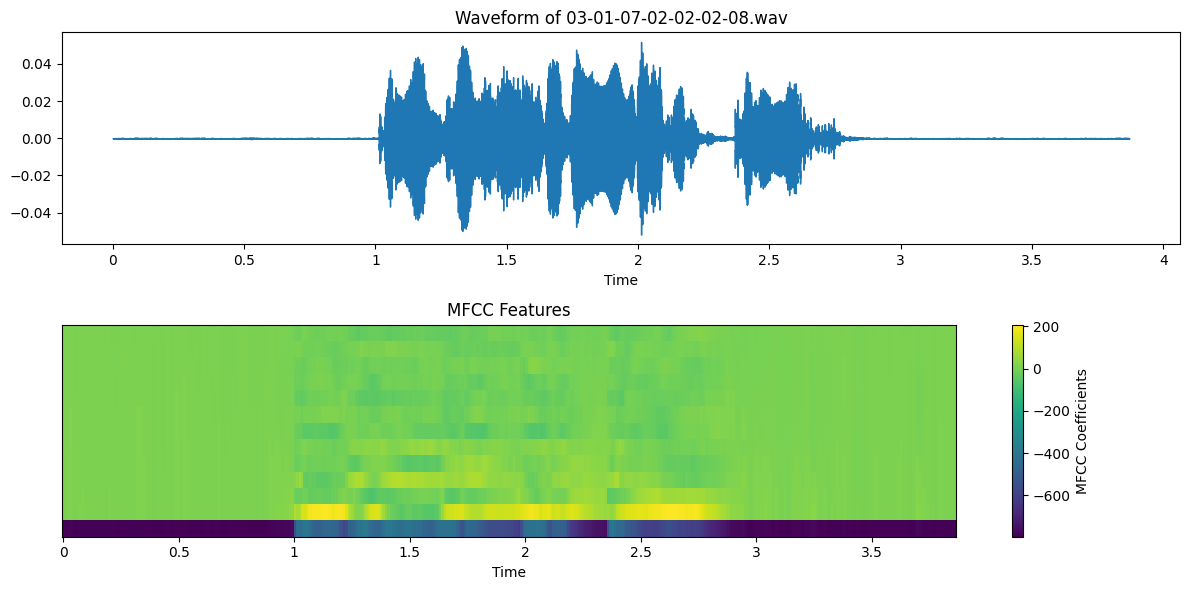

In [30]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random

# Set the path to your dataset
# dataset_path = "path_to_extracted_audio_dataset/audio/Audio_Speech_Actors_01-24"
dataset_path = "/content/drive/My Drive/Audio_Speech_Actors_01-24"  # Replace with the correct path to your dataset

# Select a random actor folder
actor_folder = random.choice(os.listdir(dataset_path))
audio_folder_path = os.path.join(dataset_path, actor_folder)

# Get a random audio file from the selected actor's folder
audio_file = random.choice(os.listdir(audio_folder_path))
audio_path = os.path.join(audio_folder_path, audio_file)

# Load the audio file
y, sr = librosa.load(audio_path, sr=None)

# Extract MFCC (Mel-Frequency Cepstral Coefficients)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot the waveform and MFCC features
plt.figure(figsize=(12, 6))

# Plot waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {audio_file}")

# Plot MFCC
plt.subplot(2, 1, 2)
librosa.display.specshow(mfcc, sr=sr, x_axis="time", cmap="viridis")
plt.colorbar(label="MFCC Coefficients")
plt.title("MFCC Features")

plt.tight_layout()
plt.show()

In [31]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import soundfile as sf

# Define a function to extract features
def extract_features(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)  # Load audio file

        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Extract Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Extract Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_mean = np.mean(mel, axis=1)

        # Combine all features into a single array
        features = np.hstack([mfcc_mean, chroma_mean, mel_mean])
        return features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Initialize lists to store features and labels
data = []
labels = []

# Iterate through each actor's folder
for actor in tqdm(os.listdir(dataset_path), desc="Processing Audio Files"):
    actor_folder_path = os.path.join(dataset_path, actor)

    if os.path.isdir(actor_folder_path):
        for audio_file in os.listdir(actor_folder_path):
            audio_path = os.path.join(actor_folder_path, audio_file)

            # Extract features
            features = extract_features(audio_path)
            if features is not None:
                # Extract label (Emotion) from filename (Assuming format: "03-01-01-01-01-01-01.wav")
                emotion_label = int(audio_file.split("-")[2])  # Extract 3rd value in filename

                # Append data and label
                data.append(features)
                labels.append(emotion_label)

# Convert to Pandas DataFrame
df = pd.DataFrame(data)
df['Emotion'] = labels

# Save the dataset to CSV
df.to_csv("emotion_features.csv", index=False)
print("Feature extraction complete. Dataset saved as 'emotion_features.csv'.")

Processing Audio Files: 100%|██████████| 24/24 [12:13<00:00, 30.55s/it]


Feature extraction complete. Dataset saved as 'emotion_features.csv'.


In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization

# Load dataset
df = pd.read_csv("emotion_features.csv")

# Extract features and labels
X = df.iloc[:, :-1].values  # Feature columns
y = df.iloc[:, -1].values   # Emotion labels

# Encode emotion labels (Convert categorical labels into numeric)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Normalize features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for CNN + LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split dataset into Training and Test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data Preprocessing Completed!")
print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Data Preprocessing Completed!
Training Samples: 1152, Testing Samples: 288


In [35]:
# Build CNN + LSTM Model
model = Sequential([
    # Convolutional Layer
    Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # LSTM Layer
    LSTM(64, return_sequences=True),
    LSTM(32),

    # Fully Connected Layers
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),

    # Output Layer (Softmax for multi-class classification)
    Dense(len(np.unique(y)), activation="softmax")
])

# Compile Model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print Model Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 151, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 151, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 75, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 75, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,408 (196.91 KB)

 Trainable params: 50,280 (196.41 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save the trained model
model.save("emotion_model.h5")
print("Model Training Completed & Saved as 'emotion_model.h5'!")

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.3807 - loss: 1.6708 - val_accuracy: 0.3299 - val_loss: 1.6560
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.3666 - loss: 1.6504 - val_accuracy: 0.3264 - val_loss: 1.6969
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.3762 - loss: 1.6109 - val_accuracy: 0.3368 - val_loss: 1.6543
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.3645 - loss: 1.6281 - val_accuracy: 0.2812 - val_loss: 1.7556
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.3494 - loss: 1.6635 - val_accuracy: 0.3333 - val_loss: 1.6836
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.3547 - loss: 1.6554 - val_accuracy: 0.3160 - val_loss: 1.6973
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.3613 - loss: 1.6339 - val_accuracy: 0.3299 - val_loss: 1.6420
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.3769 - loss: 1.6079 - val_accuracy: 0.3194 -

In [ ]:
# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")